In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
import itertools
import random
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## DataLoader

In [2]:
### handle trace from dataset
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label
    def __len__(self):
        return self.trace_num
    
### data loader for train
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
    return train_loader

### data loader for test
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)
    return test_loader

## Arrays and Functions

In [3]:
Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]

HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
            3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
            3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
            4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
            3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
            6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
            4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
            6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]

### To train a network 
def train(epoch, model, learning_rate, freeze_BN = False):
    """
    - epoch : the current epoch
    - model : the current model 
    - learning_rate : learning rate   
    """
    if freeze_BN:
        model.eval() # enter eval mode to freeze batch normalization layers
    else:
        model.train() # enter training mode 
    # Instantiate the Iterator
    iter_source = iter(source_train_loader)
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        source_data, source_label = iter_source.next()
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        optimizer.zero_grad()
        source_preds = model(source_data)
        preds = source_preds.data.max(1, keepdim=True)[1]
        correct_batch = preds.eq(source_label.data.view_as(preds)).sum()
        loss = clf_criterion(source_preds, source_label)
        # optimzie the cross-entropy loss
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size,
                100. * i / len(source_train_loader), loss.data, float(correct_batch) * 100. /batch_size))
            
### validation 
def validation(model):
    # enter evaluation mode
    model.eval()
    valid_loss = 0
    # the number of correct prediction
    correct_valid = 0
    clf_criterion = nn.CrossEntropyLoss()
    for data, label in source_valid_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        valid_preds = model(data)
        # sum up batch loss
        valid_loss += clf_criterion(valid_preds, label) 
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        # get the number of correct prediction
        correct_valid += pred.eq(label.data.view_as(pred)).cpu().sum()
    valid_loss /= len(source_valid_loader)
    valid_acc = 100. * correct_valid / len(source_valid_loader.dataset)
    print('Validation: loss: {:.4f}, accuracy: {}/{} ({:.6f}%)'.format(
        valid_loss.data, correct_valid, len(source_valid_loader.dataset),
        valid_acc))
    return valid_loss, valid_acc

### test/attack
def test(model, device_id, disp_GE=True, model_flag='pretrained'):
    """
    - model : the current model 
    - device_id : id of the tested device
    - disp_GE : whether to attack/calculate guessing entropy (GE)
    - model_flag : a string for naming GE result
    """
    # enter evaluation mode
    model.eval()
    test_loss = 0
    # the number of correct prediction
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()
    if device_id == source_device_id: # attack on the source domain
        test_num = source_test_num
        test_loader = source_test_loader
        real_key = real_key_01
    else: # attack on the target domain
        test_num = target_test_num
        test_loader = target_test_loader
        real_key = real_key_02
    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((test_num, class_num), dtype=torch.float, device='cpu')
    for data, label in test_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        test_preds = model(data)
        # sum up batch loss
        test_loss += clf_criterion(test_preds, label) 
        # get the index of the max probability
        pred = test_preds.data.max(1)[1]
        # get the softmax results for attack/showing guessing entropy
        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch*batch_size:(epoch+1)*batch_size, :] =softmax(test_preds)
        # get the predictions (predlist) and real labels (lbllist) for showing confusion matrix
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        # get the number of correct prediction
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1
    test_loss /= len(test_loader)
    print('Target test loss: {:.4f}, Target test accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # get the confusion matrix
    confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    # show the confusion matrix
    plot_sonfusion_matrix(confusion_mat, classes = range(class_num))
    # show the guessing entropy and success rate
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, device_id, model_flag)

### fine-tune a pre-trained model
def CDP_train(epoch, model, learning_rate):
    """
    - epoch : the current epoch
    - model : the current model 
    - learning_rate : learning rate   
    """
    # enter evaluation mode to freeze the BN and dropout (if have) layer when fine-tuning
    model.eval()
    # Instantiate the Iterator for source tprofiling traces
    iter_source = iter(source_train_loader)
    # Instantiate the Iterator for target traces
    iter_target = iter(target_finetune_loader)
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        # get traces and labels for source domain
        source_data, source_label = iter_source.next()
        # get traces for target domain
        target_data, _ = iter_target.next()
        # Instantiate the target Iterator again if all target traces have been used
        if i % len(target_finetune_loader) == 0:
            iter_target = iter(target_finetune_loader)
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
            target_data = target_data.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        target_data = Variable(target_data)
        optimizer.zero_grad()
        # get predictions and MMD loss
        source_preds, mmd_loss = model(source_data, target_data)
        preds = source_preds.data.max(1, keepdim=True)[1]
        # get classification loss on source doamin
        clf_loss = clf_criterion(source_preds, source_label)
        # the total loss function
        loss = clf_loss + lambda_*mmd_loss
        # optimzie the total loss
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\ttotol_loss: {:.6f}\tclf_loss: {:.6f}\tmmd_loss: {:.6f}'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size,
                100. * i / len(source_train_loader), loss.data, clf_loss.data, mmd_loss.data))

### Validation for fine-tuning phase          
def CDP_validation(model):
    # enter evaluation mode
    clf_criterion = nn.CrossEntropyLoss()
    model.eval()
    # Instantiate the Iterator for source validation traces
    iter_source = iter(source_valid_loader)
    # Instantiate the Iterator for target traces
    iter_target = iter(target_finetune_loader)
    # get the number of batches
    num_iter = len(source_valid_loader)
    # the classification loss
    totol_clf_loss = 0
    # the MMD loss
    totol_mmd_loss = 0
    # the total loss
    totol_loss = 0
    # the number of correct prediction
    correct = 0
    for i in range(1, num_iter+1):
        # get traces and labels for source domain
        source_data, source_label = iter_source.next()
        # get traces for target domain
        target_data, _ = iter_target.next()
        if i % len(target_finetune_loader) == 0:
            iter_target = iter(target_finetune_loader)
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
            target_data = target_data.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        target_data = Variable(target_data)
        valid_preds, mmd_loss = model(source_data, target_data)
        clf_loss = clf_criterion(valid_preds, source_label) 
        # sum up batch loss
        loss = clf_loss + lambda_*mmd_loss
        totol_clf_loss += clf_loss
        totol_mmd_loss += mmd_loss
        totol_loss += loss
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        correct += pred.eq(source_label.data.view_as(pred)).cpu().sum()
    totol_loss /= len(source_valid_loader)
    totol_clf_loss /= len(source_valid_loader)
    totol_mmd_loss /= len(source_valid_loader)
    print('Validation: totol_loss: {:.4f}, clf_loss: {:.4f}, mmd_loss: {:.4f}, accuracy: {}/{} ({:.2f}%)'.format(
        totol_loss.data, totol_clf_loss, totol_mmd_loss, correct, len(source_valid_loader.dataset),
        100. * correct / len(source_valid_loader.dataset)))
    return totol_loss

### test/attack
def CDP_test(model, disp_GE):
    """
    - model : the current model 
    - disp_GE : whether to attack/calculate guessing entropy (GE)
    """
    # enter evaluation mode
    model.eval()
    test_loss = 0
    # the number of correct prediction
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()
    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((target_test_num, class_num), dtype=torch.float, device='cpu')
    for data, label in target_test_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        test_preds, _ = model(data,data)
        # sum up classification loss
        test_loss += clf_criterion(test_preds, label) 
        # get the index of the max probability
        pred = test_preds.data.max(1)[1] 
        # get the softmax results for attack/showing guessing entropy
        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch*batch_size:(epoch+1)*batch_size, :] =softmax(test_preds)
        # get the predictions (predlist) and real labels (lbllist) for showing confusion matrix
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        # get the number of correct prediction
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1
    test_loss /= len(target_test_loader)
    test_acc = float(correct) / len(target_test_loader.dataset)
    print('Target average loss: {:.4f}, Target accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(target_test_loader.dataset),
        100. * test_acc))
    # get the confusion matrix
    confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    # show the confusion matrix
    plot_sonfusion_matrix(confusion_mat, classes = range(class_num))
    # show the guessing entropy and success rate
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key_02, target_device_id, model_flag='finetuned')
    return test_acc

### kernel function
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    - source : source data
    - target : target data
    - kernel_mul : multiplicative step of bandwidth (sigma)
    - kernel_num : the number of guassian kernels
    - fix_sigma : use a fix value of bandwidth
    """
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), \
                                       int(total.size(0)), \
                                       int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), \
                                       int(total.size(0)), \
                                       int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2) #|x-y|
    
    # bandwidth
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

    #exp(-|x-y|/bandwidth)
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for \
                  bandwidth_temp in bandwidth_list]

    return sum(kernel_val)

### MMD loss function based on guassian kernels
def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    - source : source data
    - target : target data
    - kernel_mul : multiplicative step of bandwidth (sigma)
    - kernel_num : the number of guassian kernels
    - fix_sigma : use a fix value of bandwidth
    """
    loss = 0.0
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,kernel_mul=kernel_mul,kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size] # Source<->Source
    YY = kernels[batch_size:, batch_size:] # Target<->Target
    XY = kernels[:batch_size, batch_size:] # Source<->Target
    YX = kernels[batch_size:, :batch_size] # Target<->Source
    loss = torch.mean(XX + YY - XY -YX)
    return loss

### show the guessing entropy and success rate
def plot_guessing_entropy(preds, real_key, device_id, model_flag):
    """
    - preds : the probability for each class (n*256 for a byte, n*9 for Hamming weight)
    - real_key : the key of the target device
    - device_id : id of the target device
    - model_flag : a string for naming GE result
    """
    # GE/SR is averaged over 100 attacks 
    num_averaged = 100
    # max trace num for attack
    trace_num_max = 5000
    # the step trace num increases
    step = 1
    if trace_num_max > 400 and trace_num_max < 1000:
        step = 2
    if trace_num_max >= 1000 and trace_num_max < 5000:
        step = 4
    if trace_num_max >= 5000 and trace_num_max < 10000:
        step = 5
    guessing_entropy = np.zeros((num_averaged, int(trace_num_max/step)))
    success_flag = np.zeros((num_averaged, int(trace_num_max/step)))
    if device_id == target_device_id:# attack on the target domain
        plaintext = plaintexts_target
    elif device_id == source_device_id:# attack on the source domain
        plaintext = plaintexts_source
    # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index = list(range(plaintext.shape[0]))
        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = plaintext[random_index[i]] ^ key_guess
                sout = Sbox[initialState]
                if labeling_method == 'identity':
                    label = sout
                elif labeling_method == 'hw':
                    label = HW_byte[sout]
                score_mat[i, key_guess] = preds[random_index[i], label]
        score_mat = np.log(score_mat + 1e-40)
        for i in range(0, int(trace_num_max/step)):
            log_likelihood = np.sum(score_mat[0:i*step+1,:], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time,i] =  list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                    success_flag[time, i] = 1
    guessing_entropy = np.mean(guessing_entropy,axis=0)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    x = range(0, trace_num_max, step)
    p1, = plt.plot(x, guessing_entropy[0:int(trace_num_max/step)],color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Guessing entropy')
    np.save('./results/entropy_'+ labeling_method + '_ascad_' + model_flag + '_'+ desync, guessing_entropy)
    plt.subplot(1, 2, 2)       
    success_flag = np.sum(success_flag, axis=0)
    success_rate = success_flag/num_averaged 
    p2, = plt.plot(x, success_rate[0:int(trace_num_max/step)], color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Success rate')
    plt.show()
    np.save('./results/success_rate_' + labeling_method + '_ascad_' + model_flag + '_' + desync, success_rate)


### show the confusion matrix
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim((len(classes)-0.5, -0.5))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()

## Setups

In [4]:
source_device_id = 0
target_device_id = 1
real_key_01 = 224 # key of the source domain
real_key_02 = 224 # key of the target domain
lambda_ = 0.1 # Penalty coefficient
labeling_method = 'identity' # labeling of trace
preprocess = None # preprocess method
batch_size = 250
finetune_epoch = 15 # epoch number for fine-tuning
lr = 0.001 # learning rate
log_interval = 50 # epoch interval to log training information
train_num = 45000
valid_num = 5000
source_test_num = 10000
target_finetune_num = 500
target_test_num = 9000
trace_offset = 0
trace_length = 700
desync = '_desync0_to_50'
source_file_path = './Data/ASCAD/'
target_file_path = './Data/ASCAD_desync50/'
no_cuda =False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9

# to load traces and labels
X_train_source = np.load(source_file_path + 'X_train.npy')
Y_train_source = np.load(source_file_path + 'Y_train.npy')
X_attack_source = np.load(source_file_path + 'X_attack.npy')
Y_attack_source = np.load(source_file_path + 'Y_attack.npy')
X_attack_target = np.load(target_file_path + 'X_attack.npy')
Y_attack_target = np.load(target_file_path + 'Y_attack.npy')

# to load plaintexts
plaintexts_source = np.load(source_file_path + 'plaintexts_attack.npy')
plaintexts_source = plaintexts_source[:,2]
plaintexts_target = np.load(target_file_path + 'plaintexts_attack.npy')
plaintexts_target = plaintexts_target[target_finetune_num:target_finetune_num+target_test_num, 2]
    
# preprocess of traces
if preprocess == 'feature_standardization':
    scaler = preprocessing.StandardScaler()
    X_train_source = scaler.fit_transform(X_train_source)
    X_attack_source = scaler.transform(X_attack_source)
    X_attack_target = scaler.transform(X_attack_target)
elif preprocess == 'feature_scaling':
    scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    X_train_source = scaler.fit_transform(X_train_source)
    X_attack_source = scaler.transform(X_attack_source)
    X_attack_target = scaler.transform(X_attack_target)
elif preprocess == 'horizontal_standardization':
    mn = np.repeat(np.mean(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    std = np.repeat(np.std(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    X_train_source = (X_train_source - mn)/std

    mn = np.repeat(np.mean(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    X_attack_source = (X_attack_source - mn)/std
    
    mn = np.repeat(np.mean(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    X_attack_target = (X_attack_target - mn)/std
    
elif preprocess == 'horizontal_scaling':
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_train_source.T)
    X_train_source = scaler.transform(X_train_source.T).T

    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_source.T)
    X_attack_source = scaler.transform(X_attack_source.T).T
    
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_target.T)
    X_attack_target = scaler.transform(X_attack_target.T).T

# parameters of data loader
kwargs_source_train = {
        'trs_file': X_train_source[0:train_num,:],
        'label_file': Y_train_source[0:train_num],
        'trace_num':train_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_valid = {
        'trs_file': X_train_source[train_num:train_num+valid_num,:],
        'label_file': Y_train_source[train_num:train_num+valid_num],
        'trace_num':valid_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_test = {
        'trs_file': X_attack_source,
        'label_file': Y_attack_source,
        'trace_num':source_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target_finetune = {
        'trs_file': X_attack_target[0:target_finetune_num,:],
        'label_file': Y_attack_target[0:target_finetune_num],
        'trace_num':target_finetune_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target = {
        'trs_file': X_attack_target[target_finetune_num:target_finetune_num+target_test_num, :],
        'label_file': Y_attack_target[target_finetune_num:target_finetune_num+target_test_num],
        'trace_num':target_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
source_train_loader = load_training(batch_size, kwargs_source_train)
source_valid_loader = load_training(batch_size, kwargs_source_valid)
source_test_loader = load_testing(batch_size, kwargs_source_test)
target_finetune_loader = load_training(batch_size, kwargs_target_finetune)
target_test_loader = load_testing(batch_size, kwargs_target)
print('Load data complete!')

Load data complete!


## Models

In [5]:
### the pre-trained model
class Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=1),
            nn.SELU(),
            nn.BatchNorm1d(32),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=50),
            nn.SELU(),
            nn.BatchNorm1d(64),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(64, 128, kernel_size=3),
            nn.SELU(),
            nn.BatchNorm1d(128),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(256, 20),
            nn.SELU(),
        )
        # the fully-connected layer 2
        self.classifier_2 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        # the fully-connected layer 3
        self.classifier_3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
    
    # how the network runs
    def forward(self, input):
        x = self.features(input)
        x = x.view(x.size(0), -1)
        x = self.classifier_1(x)
        x = self.classifier_2(x)
        x = self.classifier_3(x)
        output = self.final_classifier(x)
        return output

### the fine-tuning model
class CDP_Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(CDP_Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=1),
            nn.SELU(),
            nn.BatchNorm1d(32),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=50),
            nn.SELU(),
            nn.BatchNorm1d(64),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(64, 128, kernel_size=3),
            nn.SELU(),
            nn.BatchNorm1d(128),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(256, 20),
            nn.SELU(),
        )
        # the fully-connected layer 2
        self.classifier_2 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        # the fully-connected layer 3
        self.classifier_3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )

    # how the network runs
    def forward(self, source, target):
        mmd_loss = 0
        #source data flow
        source = self.features(source)
        source_0 = source.view(source.size(0), -1)
        source_1 = self.classifier_1(source_0)
        source_2 = self.classifier_2(source_1)
        source_3 = self.classifier_3(source_2)
        
        #target data flow
        target = self.features(target)
        target = target.view(target.size(0), -1)
        mmd_loss += mmd_rbf(source_0, target)
        target = self.classifier_1(target)
        mmd_loss += mmd_rbf(source_1, target)
        target = self.classifier_2(target)
        mmd_loss += mmd_rbf(source_2, target)
        
        result = self.final_classifier(source_3)
        return result, mmd_loss

## Results of pre-trained model on source and target devices

Construct model complete
Result on source device:
Target test loss: 5.3398, Target test accuracy: 88/10000 (0.88%)



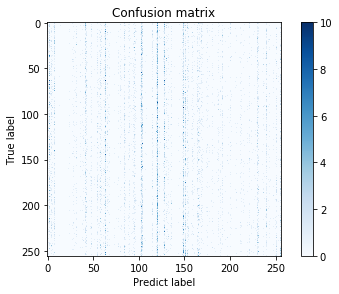

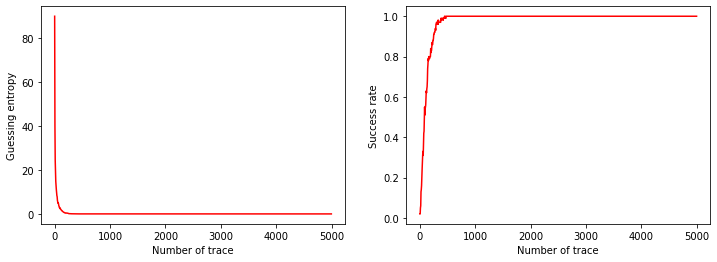

Result on target device:
Target test loss: 6.9485, Target test accuracy: 54/9000 (0.60%)



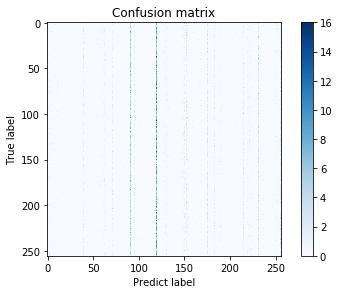

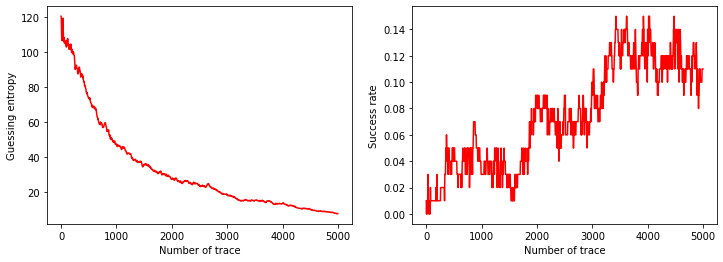

In [6]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network 
checkpoint = torch.load('./models/pre-trained.pth')
pretrained_dict = checkpoint['model_state_dict']
model_dict = pretrained_dict
model.load_state_dict(model_dict)

# evaluate the pre-trained model on source and target domain
with torch.no_grad():
    print('Result on source device:')
    test(model, source_device_id, model_flag='pretrained_source')
    print('Result on target device:')
    test(model, target_device_id, model_flag='pretrained_target')

## Train another 15 epochs, without fine-tune

In [7]:
# create a network
pretrained_model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    pretrained_model.cuda()
# initialize a big enough loss number
min_loss = 1000
# load the pre-trained model
checkpoint = torch.load('./models/pre-trained.pth')
pretrained_dict = checkpoint['model_state_dict']
pretrained_model.load_state_dict(pretrained_dict)
optimizer = optim.Adam([
        {'params': pretrained_model.features.parameters()},
        {'params': pretrained_model.classifier_1.parameters()},
        {'params': pretrained_model.classifier_2.parameters()},
        {'params': pretrained_model.classifier_3.parameters()},
        {'params': pretrained_model.final_classifier.parameters()}
    ], lr=lr)
# recover the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for epoch in range(1, finetune_epoch + 1):
    print(f'Train Epoch {epoch}:')
    train(epoch, pretrained_model, lr, freeze_BN=True)
    with torch.no_grad():
        valid_loss, _ = validation(pretrained_model)
        # save the model that achieves the lowest validation loss
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': pretrained_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './models/best_valid_loss_wo_finetune{}.pth'.format(desync))
torch.save({
    'epoch': epoch,
    'model_state_dict': pretrained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, './models/last_valid_loss_wo_finetune{}.pth'.format(desync))
torch.cuda.empty_cache()

Construct model complete
Train Epoch 1:
Train Epoch 1: [12500/45000 (28%)]	Loss: 5.250103	Acc: 0.800000%
Train Epoch 1: [25000/45000 (56%)]	Loss: 5.263419	Acc: 0.400000%
Train Epoch 1: [37500/45000 (83%)]	Loss: 5.324171	Acc: 0.800000%
Validation: loss: 5.3667, accuracy: 48/5000 (0.960000%)
Train Epoch 2:
Train Epoch 2: [12500/45000 (28%)]	Loss: 5.282098	Acc: 1.600000%
Train Epoch 2: [25000/45000 (56%)]	Loss: 5.227171	Acc: 1.200000%
Train Epoch 2: [37500/45000 (83%)]	Loss: 5.303853	Acc: 0.400000%
Validation: loss: 5.3560, accuracy: 41/5000 (0.820000%)
Train Epoch 3:
Train Epoch 3: [12500/45000 (28%)]	Loss: 5.203731	Acc: 1.600000%
Train Epoch 3: [25000/45000 (56%)]	Loss: 5.238486	Acc: 2.000000%
Train Epoch 3: [37500/45000 (83%)]	Loss: 5.260962	Acc: 0.800000%
Validation: loss: 5.3428, accuracy: 34/5000 (0.680000%)
Train Epoch 4:
Train Epoch 4: [12500/45000 (28%)]	Loss: 5.268587	Acc: 2.400000%
Train Epoch 4: [25000/45000 (56%)]	Loss: 5.298517	Acc: 1.600000%
Train Epoch 4: [37500/45000 (83%

## Cross-Device Profiling: fine-tune 15 epochs

In [8]:
# create a network 
CDP_model = CDP_Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    CDP_model.cuda()
# initialize a big enough loss number
min_loss = 1000
# load the pre-trained model
checkpoint = torch.load('./models/pre-trained.pth')
pretrained_dict = checkpoint['model_state_dict']
CDP_model.load_state_dict(pretrained_dict)
# recover the optimizer state
optimizer = optim.Adam([
        {'params': CDP_model.features.parameters()},
        {'params': CDP_model.classifier_1.parameters()},
        {'params': CDP_model.classifier_2.parameters()},
        {'params': CDP_model.classifier_3.parameters()},
        {'params': CDP_model.final_classifier.parameters()}
    ], lr=lr)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for epoch in range(1, finetune_epoch + 1):
    print(f'Train Epoch {epoch}:')
    CDP_train(epoch, CDP_model, lr)
    with torch.no_grad():
        valid_loss = CDP_validation(CDP_model)
        # save the model that achieves the lowest validation loss
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': CDP_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './models/best_valid_loss_finetuned{}.pth'.format(desync))
torch.save({
    'epoch': epoch,
    'model_state_dict': CDP_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, './models/last_valid_loss_finetuned{}.pth'.format(desync))


Construct model complete
Train Epoch 1:
Train Epoch 1: [12500/45000 (28%)]	totol_loss: 5.381011	clf_loss: 5.287819	mmd_loss: 0.931926
Train Epoch 1: [25000/45000 (56%)]	totol_loss: 5.375410	clf_loss: 5.320783	mmd_loss: 0.546267
Train Epoch 1: [37500/45000 (83%)]	totol_loss: 5.382171	clf_loss: 5.349172	mmd_loss: 0.329997
Validation: totol_loss: 5.3935, clf_loss: 5.3630, mmd_loss: 0.3055, accuracy: 42/5000 (0.84%)
Train Epoch 2:
Train Epoch 2: [12500/45000 (28%)]	totol_loss: 5.321772	clf_loss: 5.297393	mmd_loss: 0.243787
Train Epoch 2: [25000/45000 (56%)]	totol_loss: 5.327851	clf_loss: 5.307060	mmd_loss: 0.207914
Train Epoch 2: [37500/45000 (83%)]	totol_loss: 5.201480	clf_loss: 5.180344	mmd_loss: 0.211356
Validation: totol_loss: 5.3748, clf_loss: 5.3566, mmd_loss: 0.1819, accuracy: 37/5000 (0.74%)
Train Epoch 3:
Train Epoch 3: [12500/45000 (28%)]	totol_loss: 5.326461	clf_loss: 5.308887	mmd_loss: 0.175738
Train Epoch 3: [25000/45000 (56%)]	totol_loss: 5.293904	clf_loss: 5.278516	mmd_loss:

## Comparison of performance w/wo MMD loss

Results without Finetune:
Target test loss: 7.2179, Target test accuracy: 44/9000 (0.49%)



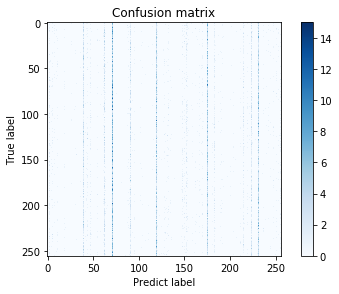

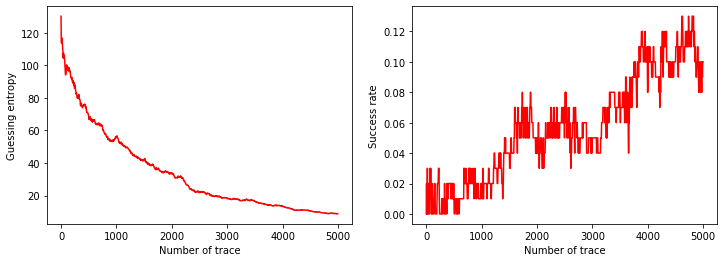

Results with Finetune:
Target average loss: 5.7881, Target accuracy: 53/9000 (0.59%)



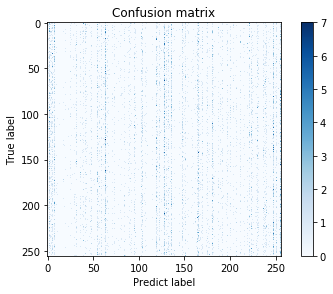

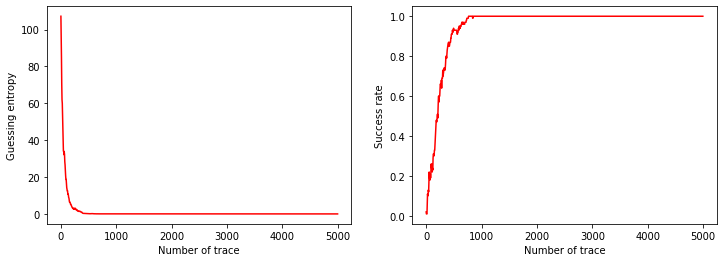

In [9]:
# load the model "train another 15 epochs without fine-tune"
print('Results without Finetune:')
pretrained_model = Net(num_classes=class_num)
if cuda:
    pretrained_model.cuda()
checkpoint = torch.load('./models/best_valid_loss_wo_finetune{}.pth'.format(desync))
pretrained_dict = checkpoint['model_state_dict']
pretrained_model.load_state_dict(pretrained_dict)
with torch.no_grad():
    test(pretrained_model, target_device_id, disp_GE=True)
    
# load the fine-tuned model
print('Results with Finetune:')
CDP_model = CDP_Net(num_classes=class_num)
if cuda:
    CDP_model.cuda()
checkpoint = torch.load('./models/best_valid_loss_finetuned{}.pth'.format(desync))
pretrained_dict = checkpoint['model_state_dict']
CDP_model.load_state_dict(pretrained_dict)
with torch.no_grad():
    CDP_test(CDP_model, disp_GE=True)